In [1]:
import os
import pandas as pd
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem,RDLogger
from catemb import CatEmb
from catemb.recommend import random_init, recommend_by_random, recommend_by_dist, recommend_by_model
from catemb.utils import link_lig_to_metal
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
RDLogger.DisableLog('rdApp.*')
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400
catemb_calc = CatEmb(device='cpu')

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## C–H arylation dataset

In [2]:
rxn_data = pd.read_csv("../dataset/rxn_data/aryl-scope-ligand.csv")
lig_smi_lst, rct1_smi_lst, rct2_smi_lst, pdt_smi_lst = rxn_data['ligand_smiles'].to_list(),rxn_data['electrophile_smiles'].to_list(),rxn_data['nucleophile_smiles'].to_list(),rxn_data['product_smiles'].to_list()
label = rxn_data['yield'].to_numpy()

In [3]:
lig_smi_yield_map = {}
for lig_smi, yield_ in zip(lig_smi_lst,label):
    if not lig_smi in lig_smi_yield_map:
        lig_smi_yield_map[lig_smi] = [yield_]
    else:
        lig_smi_yield_map[lig_smi].append(yield_)
lig_smi_ave_yield_lst = sorted([[smi,np.mean(lig_smi_yield_map[smi])] for smi in lig_smi_yield_map],key=lambda x: x[1])
tgt_lig_smi = lig_smi_ave_yield_lst[-1][0]

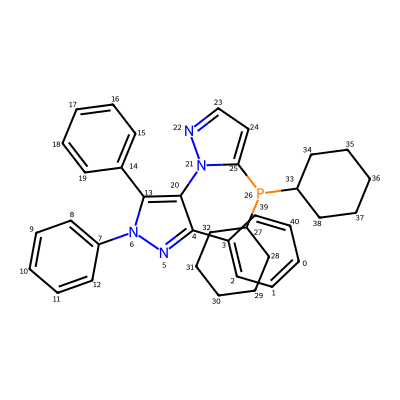

In [4]:
Chem.MolFromSmiles(tgt_lig_smi)

In [5]:
batch_size = 2
leave_best_topk = 0
recommend_time = 4
test_time = 100

### Random recommendation

In [6]:
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(lig_smi_ave_yield_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    if tgt_lig_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)

    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        if tgt_lig_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)

    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
rand_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
rand_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)

best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 32.3555, 2
20, 4
Max score: 32.5712, 4
18, 6
Max score: 38.3431, 6
16, 8
Max score: 46.1830, 8
14, 10
Max score: 46.1830, 10
best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.3

### Similarity-based recommendation

In [7]:
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(lig_smi_ave_yield_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    
    if tgt_lig_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size,best_n=1)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_lig_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
dist_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
dist_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)


best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 32.3555, 2
20, 4
Max score: 32.3555, 4


18, 6
Max score: 38.3431, 6
16, 8
Max score: 38.3431, 8
14, 10
Max score: 38.3431, 10
best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 38.3431, 2
20, 4
Max score: 38.3431, 4
18, 6
Max score: 38.3431, 6
16, 8
Max score: 38.3431, 8
14, 10
Max score: 46.1830, 10
best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(

### Model-based

In [8]:
aryl_scope_rxnfp_desc_for_recommend = np.load("./gen_desc/aryl_scope_rxnfp_desc_for_recommend.npy",allow_pickle=True).item()
rct12_pdt_pair_set = aryl_scope_rxnfp_desc_for_recommend['rct12_pdt_pair_set']
rxn_smi_fp_map = aryl_scope_rxnfp_desc_for_recommend['rxn_smi_fp_map']
rxn_smi_label_map = aryl_scope_rxnfp_desc_for_recommend['rxn_smi_label_map']
random_seed = 42
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(lig_smi_ave_yield_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    
    if tgt_lig_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_model(cur_score,cur_cat,pool_cat,rct12_pdt_pair_set,rxn_smi_fp_map,rxn_smi_label_map,model,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_lig_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
model_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
model_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)


best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 32.3555, 2
20, 4
Max score: 43.6197, 4
18, 6
Max score: 43.6197, 6
16, 8
Max score: 46.1830, 8
14, 10
Max score: 46.1830, 10
best 0 catalyst label: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.3

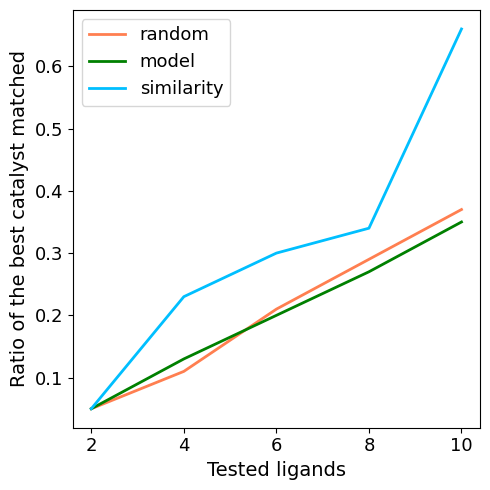

In [13]:
label_fontsize = 14
tick_fontsize = 13
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='coral',linewidth=2,label="random")
plt.plot(exp_times,model_ave_cur_match_best_arr,c='green',linewidth=2,label="model")
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='deepskyblue',linewidth=2,label="similarity")
plt.xlabel('Tested ligands',fontsize=label_fontsize)
plt.ylabel('Ratio of the best catalyst matched',fontsize=label_fontsize)
plt.xticks([2,4,6,8,10],['2','4','6','8','10'],fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=tick_fontsize)
plt.tight_layout()
os.makedirs("./recommend_results",exist_ok=True)
plt.savefig("./recommend_results/aryl_scope_model_match_best.png")
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

## Asymmetric thiol addition dataset

In [14]:
rxn_data = pd.read_csv("../dataset/rxn_data/NS_acetal_dataset_with_pdt.csv")
rxn_data

,Unnamed: 0,Imine,Thiol,Catalyst,ΔΔG,Product
0,0,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1,1,O=C(/N=C/c1ccccc1)c1ccccc1,CCS,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.501759,CCSC(NC(=O)c1ccccc1)c1ccccc1
2,2,O=C(/N=C/c1ccccc1)c1ccccc1,SC1CCCCC1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.650584,O=C(NC(SC1CCCCC1)c1ccccc1)c1ccccc1
3,3,O=C(/N=C/c1ccccc1)c1ccccc1,COc1ccc(S)cc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.238109,COc1ccc(SC(NC(=O)c2ccccc2)c2ccccc2)cc1
4,4,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccc(C(F)(F)F)cc1)c1ccccc1
...,...,...,...,...,...,...
1070,1070,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1071,1071,O=C(/N=C/c1ccccc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccccc1
1072,1072,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.370104,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1
1073,1073,O=C(/N=C/c1cccc2ccccc12)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.301167,O=C(NC(Sc1ccccc1)c1cccc2ccccc12)c1ccccc1


In [22]:
imine_lst = rxn_data['Imine'].to_list()
thiol_lst = rxn_data['Thiol'].to_list()
cat_lst = rxn_data['Catalyst'].to_list()
pdt_lst = rxn_data['Product'].to_list()
label = rxn_data['ΔΔG'].to_numpy()

cat_label_map = {}
for cat,l in zip(cat_lst,label):
    if cat not in cat_label_map:
        cat_label_map[cat] = []
    cat_label_map[cat].append(l)
cat_label_lst = sorted([[cat,np.mean(l)] for cat,l in cat_label_map.items()],key=lambda x:x[1])
tgt_cat_smi = cat_label_lst[-1][0]

In [24]:
batch_size = 2
leave_best_topk = 0
recommend_time = 9
test_time = 100

### Random recommendation

In [25]:

all_cur_best_lst = []
all_match_best_lig_lst = []
cur_max_score_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(cat_label_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    if len(cur_score) > 0:
        max_score = max(cur_score)
    else:
        max_score = 0
    cur_best_lst.append(max_score)
    exp_times.append(len(cur_score))
    if tgt_cat_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)

    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        if tgt_cat_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)

    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
rand_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
rand_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)

best 0 catalyst label: [np.float64(0.03711746028), np.float64(0.10016049476), np.float64(0.11951940963999999), np.float64(0.12085957976), np.float64(0.14336383332), np.float64(0.1512067412), np.float64(0.22700402279999998), np.float64(0.23357146856), np.float64(0.24017755047999997), np.float64(0.54519902392), np.float64(0.6235236937599999), np.float64(0.88947511908), np.float64(0.8900880875999999), np.float64(0.8995831816800001), np.float64(0.91206074284), np.float64(0.9261619985199999), np.float64(0.9316345056799998), np.float64(0.93403586644), np.float64(0.94422131788), np.float64(0.9615974247600002), np.float64(0.9640426462399999), np.float64(0.9856560910800001), np.float64(0.99051954524), np.float64(0.9918570946399998), np.float64(1.0095220376), np.float64(1.0177862683999999), np.float64(1.04296387876), np.float64(1.10050943544), np.float64(1.11206407256), np.float64(1.1337612234799999), np.float64(1.18918930644), np.float64(1.20314237828), np.float64(1.26550633744), np.float64(1.2

### Similarity-based recommendation

In [27]:
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(cat_label_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    if len(cur_score) == 0:
        max_score = 0
    else:
        max_score = max(cur_score)
    cur_best_lst.append(max_score)
    exp_times.append(len(cur_score))
    
    if tgt_cat_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size,best_n=1)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_cat_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
dist_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
dist_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)

best 0 catalyst label: [np.float64(0.03711746028), np.float64(0.10016049476), np.float64(0.11951940963999999), np.float64(0.12085957976), np.float64(0.14336383332), np.float64(0.1512067412), np.float64(0.22700402279999998), np.float64(0.23357146856), np.float64(0.24017755047999997), np.float64(0.54519902392), np.float64(0.6235236937599999), np.float64(0.88947511908), np.float64(0.8900880875999999), np.float64(0.8995831816800001), np.float64(0.91206074284), np.float64(0.9261619985199999), np.float64(0.9316345056799998), np.float64(0.93403586644), np.float64(0.94422131788), np.float64(0.9615974247600002), np.float64(0.9640426462399999), np.float64(0.9856560910800001), np.float64(0.99051954524), np.float64(0.9918570946399998), np.float64(1.0095220376), np.float64(1.0177862683999999), np.float64(1.04296387876), np.float64(1.10050943544), np.float64(1.11206407256), np.float64(1.1337612234799999), np.float64(1.18918930644), np.float64(1.20314237828), np.float64(1.26550633744), np.float64(1.2

In [30]:
rxn_merge_fp = np.load("./gen_desc/thiol_add_rxnfp_desc_for_recommend.npy")
rct12_pdt_pair_set = list(set([(imine_lst[i],thiol_lst[i],pdt_lst[i]) for i in range(len(imine_lst))]))
rxn_smi_fp_map = {f"{imine}.{thiol}>{cat}>{pdt}": rxn_merge_fp[i] for i,(imine, thiol, cat, pdt) in enumerate(zip(imine_lst, thiol_lst, cat_lst, pdt_lst))}
rxn_smi_label_map = {f"{imine}.{thiol}>{cat}>{pdt}": label[i] for i,(imine, thiol, cat, pdt) in enumerate(zip(imine_lst, thiol_lst, cat_lst, pdt_lst))}

all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(cat_label_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    if len(cur_score) == 0:
        max_score = 0
    else:
        max_score = max(cur_score)
    cur_best_lst.append(max_score)
    exp_times.append(len(cur_score))
    
    if tgt_cat_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_model(cur_score,cur_cat,pool_cat,rct12_pdt_pair_set,rxn_smi_fp_map,rxn_smi_label_map,model,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_cat_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)

model_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
model_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)

best 0 catalyst label: [np.float64(0.03711746028), np.float64(0.10016049476), np.float64(0.11951940963999999), np.float64(0.12085957976), np.float64(0.14336383332), np.float64(0.1512067412), np.float64(0.22700402279999998), np.float64(0.23357146856), np.float64(0.24017755047999997), np.float64(0.54519902392), np.float64(0.6235236937599999), np.float64(0.88947511908), np.float64(0.8900880875999999), np.float64(0.8995831816800001), np.float64(0.91206074284), np.float64(0.9261619985199999), np.float64(0.9316345056799998), np.float64(0.93403586644), np.float64(0.94422131788), np.float64(0.9615974247600002), np.float64(0.9640426462399999), np.float64(0.9856560910800001), np.float64(0.99051954524), np.float64(0.9918570946399998), np.float64(1.0095220376), np.float64(1.0177862683999999), np.float64(1.04296387876), np.float64(1.10050943544), np.float64(1.11206407256), np.float64(1.1337612234799999), np.float64(1.18918930644), np.float64(1.20314237828), np.float64(1.26550633744), np.float64(1.2

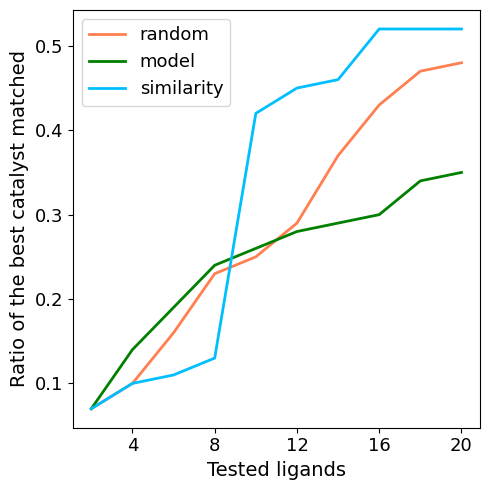

In [32]:
label_fontsize = 14
tick_fontsize = 13
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='coral',linewidth=2,label="random")
plt.plot(exp_times,model_ave_cur_match_best_arr,c='green',linewidth=2,label="model")
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='deepskyblue',linewidth=2,label="similarity")
plt.xlabel('Tested ligands',fontsize=label_fontsize)
plt.ylabel('Ratio of the best catalyst matched',fontsize=label_fontsize)
plt.xticks([4,8,12,16,20],['4','8','12','16','20'],fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=tick_fontsize)
plt.tight_layout()
plt.savefig("./recommend_results/thiol_add_model_match_best_lig.png")
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

## Suzuki–Miyaura cross-coupling

In [34]:

rxn_data = pd.read_csv('../dataset/rxn_data/com_data_with_cplex_smi.csv')
lig_lib = np.load("../dataset/rxn_data/smi_sascore_map.npy",allow_pickle=True).item()
sel_lig_lib_by_sascore = {k: v for k, v in lig_lib.items() if v < 4}
sel_lig_lib_by_sascore_lst = list(sel_lig_lib_by_sascore.keys())
existed_lig_smi_lst = rxn_data['lig_smi'].to_list()
remain_lig_smi_lst = list(set(sel_lig_lib_by_sascore_lst) - set(existed_lig_smi_lst))
ddg_arr = rxn_data['ddG'].to_numpy()
ee_arr = rxn_data['ee'].to_numpy()

best_topk_lig_idx_lst = np.abs(ee_arr).argsort()[::-1][:1]
print(ee_arr[best_topk_lig_idx_lst])

tgt_lig_smi_ddg_map = {'CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1':0.91,
                       'Cc1ccc([C@@H](CP(c2ccccc2)c2ccccc2)N(Cc2ccccc2)[S@](=O)C(C)(C)C)cc1':0.88,
                       'Cc1ccc(CN([C@H](CP(c2ccccc2)c2ccccc2)c2ccccc2)[S@](=O)C(C)(C)C)cc1':0.93}

[0.66]


Build Ni-ligand complex

In [36]:
sadphos_smarts_idx_map = {
                      '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O': [3,8], # P, S
                      'PccCN([*])[S@@X3]([*])=O':[0,6]
                      }
sadphos_smi_scaffold_map = {k: Chem.MolFromSmarts(k) for k,v in sadphos_smarts_idx_map.items()}
lig_smi_cat_smi_map = {}
for smi in remain_lig_smi_lst+existed_lig_smi_lst:
    mol = Chem.MolFromSmiles(smi)
    match_ = False
    for scaffold_smi in sadphos_smi_scaffold_map.keys():
        scaffold = sadphos_smi_scaffold_map[scaffold_smi]
        atom_idx = sadphos_smarts_idx_map[scaffold_smi]
        if mol.HasSubstructMatch(scaffold):
            match_ = True
            match_idx = mol.GetSubstructMatch(scaffold)
            coord_at_idx_lst = [match_idx[idx] for idx in atom_idx]
            coord_at_types = [mol.GetAtomWithIdx(idx).GetSymbol() for idx in coord_at_idx_lst]
            assert 'P' in coord_at_types and 'S' in coord_at_types
            cat_mol = link_lig_to_metal(mol,'Ni',coord_at_idx_lst,2)
            lig_smi_cat_smi_map[smi] = Chem.MolToSmiles(cat_mol)
            break
    if not match_:
        print(smi)


In [38]:
lig_smi_cat_smi_map

{'COc1cccc(OC)c1[C@@H](CP(C(C)(C)C)C(C)(C)C)N(Cc1ccc(F)cc1)[S@](=O)C(C)(C)C': 'COc1cccc(OC)c1[C@H]1C[P](->[Ni+2]<-[S@](=O)(N1Cc1ccc(F)cc1)C(C)(C)C)(C(C)(C)C)C(C)(C)C',
 'C=CCN([C@H](CP(c1cccc2ccccc12)c1cccc2ccccc12)c1ccco1)[S@](=O)C(C)(C)C': 'C=CCN1[C@H](C[P](->[Ni+2]<-[S@@]1(=O)C(C)(C)C)(c1cccc2ccccc12)c1cccc2ccccc12)c1ccco1',
 'C=CCN([C@H](CP(c1ccc(C)cc1)c1ccc(C)cc1)c1cccnc1)[S@](=O)C(C)(C)C': 'C=CCN1[C@H](C[P](->[Ni+2]<-[S@@]1(=O)C(C)(C)C)(c1ccc(C)cc1)c1ccc(C)cc1)c1cccnc1',
 'COc1ccc(P(C[C@H](c2cccnc2)N(Cc2ccc(C#N)cc2)[S@](=O)C(C)(C)C)c2ccc(OC)cc2)cc1': 'COc1ccc([P]2(C[C@H](c3cccnc3)N(Cc3ccc(C#N)cc3)[S@@](=O)(->[Ni+2]<-2)C(C)(C)C)c2ccc(OC)cc2)cc1',
 'CC(C)(C)[S@@](=O)N(Cc1c(F)cccc1F)[C@H](CP(c1ccccc1)c1ccccc1)C1CCCCC1': 'CC(C)(C)[S@]1(=O)->[Ni+2]<-[P](C[C@H](C2CCCCC2)N1Cc1c(F)cccc1F)(c1ccccc1)c1ccccc1',
 'Cc1ccc(P(C[C@@H](N(Cc2ccccn2)[S@](=O)C(C)(C)C)C(C)(C)C)c2ccc(C)cc2)cc1': 'Cc1ccc([P]2(C[C@@H](N(Cc3ccccn3)[S@@](=O)(->[Ni+2]<-2)C(C)(C)C)C(C)(C)C)c2ccc(C)cc2)cc1',
 'CC(C)(C)[S@@](

In [37]:
remain_cat_smi_lst = [lig_smi_cat_smi_map[smi] for smi in remain_lig_smi_lst]
existed_cat_smi_lst = [lig_smi_cat_smi_map[smi] for smi in existed_lig_smi_lst]

In [39]:
existed_cat_desc_arr = catemb_calc.gen_desc(existed_cat_smi_lst)
remain_cat_desc_arr = catemb_calc.gen_desc(remain_cat_smi_lst)

In [40]:
best_existed_cat_desc_arr = existed_cat_desc_arr[best_topk_lig_idx_lst]
dist_of_remain_to_best = np.array([np.linalg.norm(arr - remain_cat_desc_arr,axis=1) for arr in best_existed_cat_desc_arr])
dist_score = dist_of_remain_to_best.sum(0)
remain_smi_dist_score_lst = sorted([[smi,score] for smi,score in zip(remain_lig_smi_lst,dist_score)],key=lambda x:x[1])
for idx,item in enumerate(remain_smi_dist_score_lst):
    if item[0] in tgt_lig_smi_ddg_map.keys():
        print(idx,item)

5 ['CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1', np.float32(0.33443776)]
98 ['Cc1ccc(CN([C@H](CP(c2ccccc2)c2ccccc2)c2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.5469437)]
100 ['Cc1ccc([C@@H](CP(c2ccccc2)c2ccccc2)N(Cc2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.54929507)]
